Epoch [1/50], Loss: 0.2067
Epoch [2/50], Loss: 0.0209
Epoch [3/50], Loss: 0.0076
Epoch [4/50], Loss: 0.0065
Epoch [5/50], Loss: 0.0064
Epoch [6/50], Loss: 0.0052
Epoch [7/50], Loss: 0.0054
Epoch [8/50], Loss: 0.0049
Epoch [9/50], Loss: 0.0047
Epoch [10/50], Loss: 0.0051
Epoch [11/50], Loss: 0.0040
Epoch [12/50], Loss: 0.0035
Epoch [13/50], Loss: 0.0042
Epoch [14/50], Loss: 0.0032
Epoch [15/50], Loss: 0.0027
Epoch [16/50], Loss: 0.0029
Epoch [17/50], Loss: 0.0028
Epoch [18/50], Loss: 0.0029
Epoch [19/50], Loss: 0.0025
Epoch [20/50], Loss: 0.0027
Epoch [21/50], Loss: 0.0027
Epoch [22/50], Loss: 0.0021
Epoch [23/50], Loss: 0.0025
Epoch [24/50], Loss: 0.0023
Epoch [25/50], Loss: 0.0022
Epoch [26/50], Loss: 0.0026
Epoch [27/50], Loss: 0.0031
Epoch [28/50], Loss: 0.0028
Epoch [29/50], Loss: 0.0022
Epoch [30/50], Loss: 0.0016
Epoch [31/50], Loss: 0.0015
Epoch [32/50], Loss: 0.0019
Epoch [33/50], Loss: 0.0016
Epoch [34/50], Loss: 0.0016
Epoch [35/50], Loss: 0.0022
Epoch [36/50], Loss: 0.0021
E

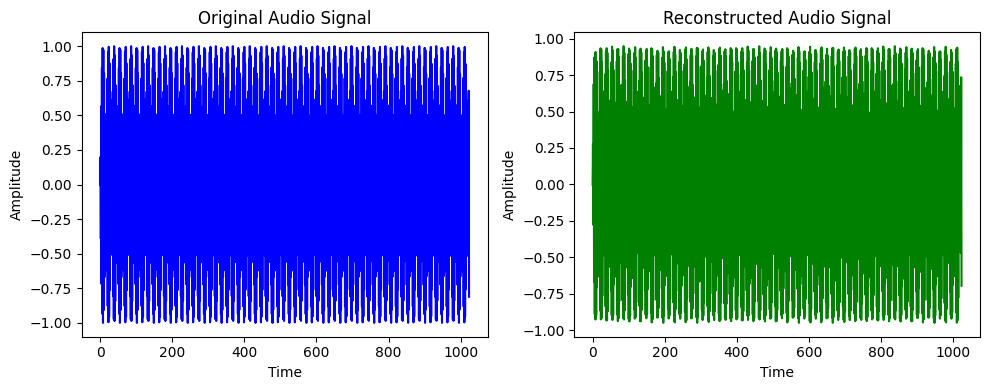

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchaudio
import matplotlib.pyplot as plt

# 1. Define the Convolutional Autoencoder

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=4, stride=2, padding=1),  # Conv Layer
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),  # Conv Layer
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),  # Conv Layer
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),  # Transposed Conv Layer
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),  # Transposed Conv Layer
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),  # Final Transposed Conv
            nn.Tanh()  # Tanh to output values between -1 and 1 (like raw audio signals)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 2. Define the Dataset (for simplicity, using a sine wave dataset for audio compression demo)

class SineWaveDataset(Dataset):
    def __init__(self, num_samples, sample_length, freq_range):
        self.num_samples = num_samples
        self.sample_length = sample_length
        self.freq_range = freq_range

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        freq = torch.rand(1).item() * (self.freq_range[1] - self.freq_range[0]) + self.freq_range[0]
        t = torch.linspace(0, 1, self.sample_length)
        sine_wave = torch.sin(2 * torch.pi * freq * t)
        return sine_wave.unsqueeze(0)  # Add channel dimension

# 3. Training the Autoencoder

def train_autoencoder(model, dataloader, num_epochs=50, learning_rate=0.001):
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for data in dataloader:
            # Send data to GPU if available
            data = data.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, data)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print("Training completed.")

# 4. Visualize Results

def visualize_reconstruction(model, dataset, device):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    with torch.no_grad():
        # Get the first sample from the dataset
        original = dataset[0].unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Pass through the model for reconstruction
        reconstructed = model(original)

        # Detach from the computation graph and move back to CPU for plotting
        original = original.squeeze().cpu().numpy()
        reconstructed = reconstructed.squeeze().cpu().numpy()

        # Plot the original and reconstructed waveforms
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(original, label="Original", color="blue")
        plt.title("Original Audio Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")

        plt.subplot(1, 2, 2)
        plt.plot(reconstructed, label="Reconstructed", color="green")
        plt.title("Reconstructed Audio Signal")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")

        plt.tight_layout()
        plt.show()

# 5. Main Execution Block

if __name__ == "__main__":
    # Set device (GPU if available)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize dataset and dataloader
    sine_wave_dataset = SineWaveDataset(num_samples=1000, sample_length=1024, freq_range=[100, 500])
    dataloader = DataLoader(sine_wave_dataset, batch_size=32, shuffle=True)

    # Initialize model
    model = ConvAutoencoder().to(device)

    # Train model
    train_autoencoder(model, dataloader, num_epochs=50, learning_rate=0.001)

    # Visualize reconstruction
    visualize_reconstruction(model, sine_wave_dataset, device)
